---
title: "Spotify Project"
subtitle: "Class prediction model"
author: "Oleg Ryzhkov (oryzhkov@chicagobooth.edu)"
date: March 14, 2021
output: CART class prediction 
---

In [2]:
library(Hmisc)
library(caret) 
library(purrr)
library(dplyr)
library(caret)
library(mboost)
library(kernlab)
library(caTools)
library(randomForest)
library(pROC) # for AUC calculations
library(dplyr) # for data manipulation
library(DMwR)   # for smote implementation

In [3]:
# Load dataset and look at class proportion
target.subset <- read.csv('../data/target_class_radiohit.csv')
table(target.subset$radio.hit)


    0     1 
42211   160 

In [4]:
target.subset$radio.hit <- as.factor(target.subset$radio.hit)
levels(target.subset$radio.hit)[levels(target.subset$radio.hit)=="0"] <- "Class_0"
levels(target.subset$radio.hit)[levels(target.subset$radio.hit)=="1"] <- "Class_1"
str(target.subset)

'data.frame':	42371 obs. of  25 variables:
 $ radio.hit              : Factor w/ 2 levels "Class_0","Class_1": 1 1 1 1 1 1 1 1 1 1 ...
 $ acousticness           : num  0.394 0.255 0.406 0.887 0.938 0.36 0.881 0.955 0.888 0.93 ...
 $ danceability           : num  0.484 0.405 0.477 0.319 0.269 0.617 0.644 0.627 0.581 0.442 ...
 $ duration_ms            : int  160187 141987 157093 187333 236800 114987 313093 295093 183440 147907 ...
 $ energy                 : num  0.265 0.365 0.352 0.201 0.129 0.711 0.212 0.184 0.331 0.399 ...
 $ explicit               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ instrumentalness       : num  0.00 4.68e-06 0.00 0.00 4.87e-06 1.59e-06 2.22e-05 1.62e-04 1.50e-05 4.99e-04 ...
 $ key                    : int  0 6 1 7 7 9 11 1 6 6 ...
 $ liveness               : num  0.149 0.163 0.122 0.904 0.683 0.0841 0.798 0.0986 0.147 0.912 ...
 $ loudness               : num  -11.1 -10.2 -14.2 -17.8 -18.2 ...
 $ mode                   : int  1 0 1 1 0 1 1 1 1 1 ...
 $ speechiness  

In [6]:
# Drop columns containg artists ranking data
artist.rank_mean <- which(colnames(target.subset) == 'artist.rank_mean') # column number 7
artist.rank_sum <- which(colnames(target.subset) == 'artist.rank_sum') # column number 7
target.subset <- target.subset[,-c(artist.rank_mean, artist.rank_sum)]
colnames(target.subset)

[1] "radio.hit"               "acousticness"           
 [3] "danceability"            "duration_ms"            
 [5] "energy"                  "explicit"               
 [7] "instrumentalness"        "key"                    
 [9] "liveness"                "loudness"               
[11] "mode"                    "speechiness"            
[13] "tempo"                   "valence"                
[15] "year"                    "language.english"       
[17] "language.catalan"        "language.german"        
[19] "language.frisian"        "language.welsh"         
[21] "artist.number"           "artist.trackcount"      
[23] "artist.trackrankedcount"

In [7]:
# Split Data
set.seed(123)
in.train = createDataPartition(target.subset$radio.hit, p=0.6, list=FALSE)
train.df = target.subset[in.train,]
cat('Target subset Radiohit, training data:')
table(train.df$radio.hit)
test.df = target.subset[-in.train,]
cat('\nTarget subset Radiohit, test data:')
table(test.df$radio.hit)

Target subset Radiohit, training data:


Class_0 Class_1 
  25327      96 


Target subset Radiohit, test data:


Class_0 Class_1 
  16884      64 

### Initial Fit

In [8]:
# Set up control function for training
ctrl <- trainControl(method = "repeatedcv",
                     number = 5,
                     repeats = 1,
                     summaryFunction = twoClassSummary,
                     search = "random",
                     classProbs = TRUE)

In [9]:
# Build a standard classifier using
# logistic regression (method LogitBoost)
set.seed(1)

log_fit.all <- train(radio.hit ~ .,
                  data = train.df,
                  method = "LogitBoost",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl,
                  tuneLength = 10)
log_fit.all

Boosted Logistic Regression 

25423 samples
   22 predictor
    2 classes: 'Class_0', 'Class_1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 20339, 20339, 20338, 20338, 20338 
Resampling results across tuning parameters:

  nIter  ROC        Sens       Spec      
   1     0.5000000  1.0000000  0.00000000
  14     0.8836783  1.0000000  0.00000000
  34     0.8742338  0.9998813  0.00000000
  39     0.8688479  0.9993288  0.00000000
  43     0.8783368  0.9994472  0.01052632
  51     0.8581984  0.9994077  0.02052632
  59     0.8703341  0.9995262  0.00000000
  82     0.8773591  0.9997624  0.00000000
  87     0.8811972  0.9994867  0.02000000
  97     0.8817618  0.9991708  0.00000000

ROC was used to select the optimal model using the largest value.
The final value used for the model was nIter = 14.

In [10]:
# Build a standard classifier using ranger
set.seed(1)

rf_fit.all <- train(radio.hit ~ .,
                  data = train.df,
                  method = "ranger",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl,
                  tuneLength = 10)
rf_fit.all

Random Forest 

25423 samples
   22 predictor
    2 classes: 'Class_0', 'Class_1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 20339, 20339, 20338, 20338, 20338 
Resampling results across tuning parameters:

  min.node.size  mtry  splitrule   ROC        Sens       Spec
   1              7    extratrees  0.9101371  0.9998026  0   
   1             14    extratrees  0.9148824  0.9998815  0   
   2              9    extratrees  0.9195640  0.9998815  0   
   7             10    extratrees  0.9246590  1.0000000  0   
  10              5    gini        0.9188286  1.0000000  0   
  11             15    gini        0.8995338  0.9999605  0   
  14              5    extratrees  0.9277773  1.0000000  0   
  14             21    extratrees  0.9217636  1.0000000  0   
  18              5    gini        0.9045757  1.0000000  0   
  19              9    gini        0.9078694  1.0000000  0   

ROC was used to select the optimal model using the la

### Examine results on test data

In [11]:
# Build custom AUC function to extract AUC
# from the caret model object
test_roc <- function(model, data) {
  roc(data$radio.hit,
      predict(model, data, type = "prob")[, "Class_1"])
}

In [12]:
# Examine results for the test set.
initial.model_list <- list(
                    log_all = log_fit.all,
                    rf_all = rf_fit.all)

initial.model_list_roc <- initial.model_list %>%
  map(test_roc, data = test.df)

cat('\nInitial models, AUC results:\n')
initial.model_list_roc %>% map(auc)

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases




Initial models, AUC results:


$log_all
Area under the curve: 0.8336

$rf_all
Area under the curve: 0.896

### Weighted and sampling methods
* incorporating weights into the model can be handled by using the weights argument in the train function
* sampling methods can be implemented using the sampling argument in the trainControl function

In [13]:
# Build down-sampled model
ctrl$sampling <- "down"
down.all_rf.fit <- train(radio.hit ~ .,
                  data = train.df,
                  method = "ranger",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl,
                  tuneLength = 10)
down.all_rf.fit

Random Forest 

25423 samples
   22 predictor
    2 classes: 'Class_0', 'Class_1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 20339, 20338, 20338, 20338, 20339 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  min.node.size  mtry  splitrule   ROC        Sens       Spec     
   6             14    extratrees  0.9369769  0.8450276  0.9368421
  10              7    gini        0.9332748  0.8764949  0.8952632
  10              9    extratrees  0.9415858  0.8323528  0.9368421
  13             18    gini        0.9219097  0.8729021  0.8536842
  14             10    gini        0.9266571  0.8751530  0.8963158
  16              5    extratrees  0.9365324  0.8200347  0.9263158
  17             10    gini        0.9319879  0.8813907  0.8852632
  19             12    extratrees  0.9382545  0.8376444  0.8847368
  19             20    gini        0.9236845  0.8668224  0.9263158
  20              7    ext

In [15]:
# Build smote model
ctrl$sampling <- "smote"
smote.all_rf.fit <- train(radio.hit ~ .,
                   data = train.df,
                  method = "ranger",
                  verbose = FALSE,
                  metric = "ROC",
                  trControl = ctrl,
                  tuneLength = 10)
smote.all_rf.fit

Random Forest 

25423 samples
   22 predictor
    2 classes: 'Class_0', 'Class_1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 20339, 20339, 20338, 20338, 20338 
Addtional sampling using SMOTE

Resampling results across tuning parameters:

  min.node.size  mtry  splitrule   ROC        Sens       Spec     
   1              4    gini        0.9249533  0.9409328  0.7094737
   2             13    gini        0.9277407  0.9321675  0.7489474
   4              5    extratrees  0.9357343  0.9159398  0.7515789
   8              8    gini        0.9337043  0.9393140  0.7305263
   9              3    gini        0.9369350  0.9479606  0.6684211
  10              6    gini        0.9353640  0.9372607  0.7205263
  12              8    gini        0.9254113  0.9421959  0.6778947
  16              6    extratrees  0.9365890  0.9134516  0.7405263
  18              7    gini        0.9321521  0.9409722  0.7100000
  18             14    gini       

In [16]:
# Examine results for the test set.
selected.model_list <- list(
                    log_all = log_fit.all,
                    rf_all = rf_fit.all,
                    down_sample_rf = down.all_rf.fit,
                    smote_sample_rf = smote.all_rf.fit)

selected.model_list_roc <- selected.model_list %>%
  map(test_roc, data = test.df)

cat('\nSelected models, AUC results:\n')
selected.model_list_roc %>% map(auc)

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases

Setting levels: control = Class_0, case = Class_1

Setting direction: controls < cases




Selected models, AUC results:


$log_all
Area under the curve: 0.8336

$rf_all
Area under the curve: 0.896

$down_sample_rf
Area under the curve: 0.9162

$smote_sample_rf
Area under the curve: 0.9215

In [19]:
all.results_list_roc <- list(NA)
num_mod <- 1

for(the_roc in selected.model_list_roc){
  all.results_list_roc[[num_mod]] <- 
    tibble(tpr = the_roc$sensitivities,
               fpr = 1 - the_roc$specificities,
               model = names(selected.model_list)[num_mod])
  num_mod <- num_mod + 1
}

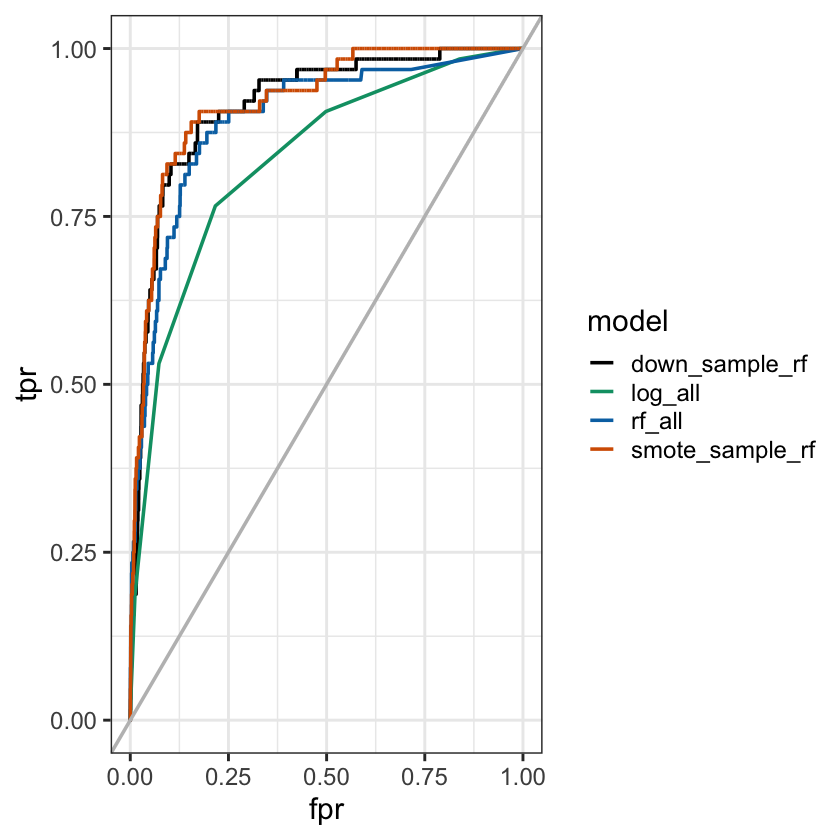

In [21]:
all.results_df_roc <- bind_rows(all.results_list_roc)
nmethod = length(selected.model_list)
# Plot ROC curve for all models
custom_col <- c("#000000", "#009E73", "#0072B2", "#D55E00")

ggplot(aes(x = fpr,  y = tpr, group = model), data = all.results_df_roc) +
  geom_line(aes(color = model), size = 1) +
  scale_color_manual(values = custom_col) +
  geom_abline(intercept = 0, slope = 1, color = "gray", size = 1) +
  theme_bw(base_size = 18)
# legend("bottomright",legend=names(rfSelected.model_list),col=1:nmethod,lty=rep(1,nmethod), lwd=2)